## Preprocessing : scaling, cleaning, encoding, grouping genres

In [8]:
import os 
import pandas as pd
import numpy as np 
import sys

In [9]:
RAW_CSV_PATH="/Users/essalehachraf/Desktop/Spotify-sHits-Unsupervised_Learning_Challenge/data /raw/playlist_2010to2022.csv"
PROC_DIR="/Users/essalehachraf/Desktop/Spotify-sHits-Unsupervised_Learning_Challenge/data /processed"
PROC_PATH=os.path.join(PROC_DIR,"playlist_2010to2022_clean.csv")

In [10]:
#to be sure that our raw data set is not modified after the EDA 
df=pd.read_csv(RAW_CSV_PATH)
print(f"shape of our data set : {df.shape}")
print(f"Number of missing values per column :\n{df.isna().sum()}")
print(f"Number of duplicate rows :\t {df.duplicated().sum()}")
print(f"Dtypes: \n{df.dtypes}")

shape of our data set : (2300, 23)
Number of missing values per column :
playlist_url         0
year                 0
track_id             0
track_name           0
track_popularity     0
album                0
artist_id            0
artist_name          0
artist_genres        0
artist_popularity    0
danceability         1
energy               1
key                  1
loudness             1
mode                 1
speechiness          1
acousticness         1
instrumentalness     1
liveness             1
valence              1
tempo                1
duration_ms          1
time_signature       1
dtype: int64
Number of duplicate rows :	 0
Dtypes: 
playlist_url          object
year                   int64
track_id              object
track_name            object
track_popularity       int64
album                 object
artist_id             object
artist_name           object
artist_genres         object
artist_popularity      int64
danceability         float64
energy               float6

- We have seen during the EDA that we only have one row with 13 missing values . We gonna drop it and save the new data in procced file .

In [11]:
rows_with_na=df[df.isna().any(axis=1)]
print("the number of rows with missing value is : ",rows_with_na.shape[0])
df_clean=df.dropna().reset_index(drop=True)
print("The number of rows of the cleaned data set is: ",df_clean.shape[0])
print("Is there any missing value in the cleaned data set ? ", df_clean.isna().any().any()) #au moins une ligne avec une valeur == na ? 

the number of rows with missing value is :  1
The number of rows of the cleaned data set is:  2299
Is there any missing value in the cleaned data set ?  False


In [12]:
df_clean.to_csv(PROC_PATH, index=False)
print("Saved cleaned data to : ", PROC_PATH)

Saved cleaned data to :  /Users/essalehachraf/Desktop/Spotify-sHits-Unsupervised_Learning_Challenge/data /processed/playlist_2010to2022_clean.csv


- We know that in unsupervised learning we don't have labels . So our objective is to discover groups of tracks based on their audio features.
- We wanna find cluters of songs that sounds similar , based on their numerical characterisics like tempo , energy valence (all numerical ! PCA..)...and then add popularity too
- We have to drop some features that are not gonna help us in what we are trying to do ( as we have seen in the course 2 about feature selection)
- To do it in a professional way we gonna creat two data frames : one with features that we believe are going to help us procede in our clustering and the second one will contain a metadata that we gonna use to interpret clusters later 

In [13]:
MODEL_PATH=os.path.join(PROC_DIR,"playlist_2000to2022_numeric.csv")
META_PATH=os.path.join(PROC_DIR,"playlist_2000to2022_metadata.csv")

meta_cols = ['playlist_url', 'year', 'track_id', 'track_name', 'album',
             'artist_id', 'artist_name', 'artist_genres', 'track_popularity', 'artist_popularity']
numeric_candidates = [
    'danceability','energy','key','loudness','mode','speechiness','acousticness',
    'instrumentalness','liveness','valence','tempo','duration_ms','time_signature']

#create our 2 dataframes 
df_meta = df_clean[meta_cols].copy()
df_model = df_clean[numeric_candidates].copy()

print(f"the shape of our meta data {df_meta.shape}")
print(f"the shape of our meta data {df_model.shape}")

#add them to our data/process 
df_meta.to_csv(META_PATH,index=False)
df_model.to_csv(MODEL_PATH,index=False)

the shape of our meta data (2299, 10)
the shape of our meta data (2299, 13)


- We have seen in EDA that : [pop] and [dancepop , pop] are the most frequent genres , as they are above 120 . Moreover the other 8 genres don't cross 40 .
- Now we're going to groupe this feature  that have many genres in the list but few samples to get meaninful insights ,to do that we gonna - suppose - that the 'artist_genres' is grouped by the most relevant genre, wich means we are going to keep only the first genre for each list - tradeoff between  simplicity and precision... 
- We can see that the lists containing only one genre are not between " " but those with 2 or plus genres are between " " . -> we gonna use ast.literal_eval() that turns "['pop', 'dance pop']" into ['pop', 'dance pop']
- 

In [14]:
from src.data_preprocessing import extract_first_genre

# Apply genre extraction
df_meta['primary_genre'] = df_meta['artist_genres'].apply(extract_first_genre)

# Group long tail
top_k = 8
top_genres = df_meta['primary_genre'].value_counts().nlargest(top_k).index.tolist()
df_meta['genre_grouped'] = df_meta['primary_genre'].apply(lambda g: g if g in top_genres else 'Other')

# Quick checks
print("Top genres (kept):", top_genres)
print("\nGrouped genre counts (top 12):")
print(df_meta['genre_grouped'].value_counts().head(12))

# Optional: Visualize results
import matplotlib.pyplot as plt
df_meta['genre_grouped'].value_counts().head(12).plot(kind='bar')
plt.title('Top 12 Genre Groups')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()

ModuleNotFoundError: No module named 'src'

- We can see that more than 56% of artist_genre felt into others , so choosing only the first genre in the list based on the suppposition that  the 'artist_genres' is grouped by the most relevant genre wich reduce interpretability 
- We had two propositions to test : i) the first one is a flatten & count flatten evry artist's genre list and then count the frequency of each genre and keep the top K ones 
ii) the second one is a keyw word mapping priority we're going to look for the presence of core tokens like 'pop' , 'rock','hip hop' etc ...
- we gonna use a hybrid method mixing those two ideas , since both of them have pros and cons :( first we gonna flatten and count keep K genres and put the rest in 'others' then use the mapping priority to assign others to one of the K most present ones based on their name )

In [15]:
#Flatten genres across dataset and get global counts
import ast
from collections import Counter

def parse_genre_list(val):
    """Return a list of genre strings for a cell that may be
       a stringified Python list or a comma-separated string or a real list."""
    if pd.isna(val):
        return []
    if isinstance(val, (list, tuple)):
        return [g.strip().lower() for g in val if isinstance(g, str)]
    if isinstance(val, str):
        # Try to parse stringified list
        try:
            parsed = ast.literal_eval(val)
            if isinstance(parsed, (list, tuple)):
                return [g.strip().lower() for g in parsed if isinstance(g, str)]
        except Exception:
            # fallback: comma-separated
            parts = [p.strip().lower() for p in val.split(',') if p.strip()]
            return parts
    return []

# Apply: create a column with parsed lists (keeps lowercase)
df_meta['genre_list'] = df_meta['artist_genres'].apply(parse_genre_list)

# Flatten and count
flat = [g for sub in df_meta['genre_list'] for g in sub]
genre_counts = Counter(flat)
# Convert to DataFrame for easy viewing
genre_counts_df = (pd.DataFrame.from_records(list(genre_counts.items()), columns=['genre','count'])
                     .sort_values('count', ascending=False)
                     .reset_index(drop=True))
genre_counts_df.head(30)


,genre,count
0,pop,993
1,dance pop,537
2,rap,383
3,pop rap,305
4,hip hop,250
5,r&b,231
6,urban contemporary,214
7,trap,134
8,southern hip hop,132
9,modern rock,128


- This confirms a strong pop dominance  followed by rap / hip-hop / R&B families
 we  already see clear macro trends this means grouping them is justified (many micro tags describing similar styles)..

In [16]:
#  Pick top-N frequent raw tags
top_n = 15
top_tags = genre_counts_df.head(top_n)['genre'].tolist()
print("Top tags (exact):", top_tags)

# How many remaining unique tags?
print("Unique raw tags total:", len(genre_counts_df))
print("Number in 'Other' if we only keep top_n:", len(genre_counts_df) - top_n)


Top tags (exact): ['pop', 'dance pop', 'rap', 'pop rap', 'hip hop', 'r&b', 'urban contemporary', 'trap', 'southern hip hop', 'modern rock', 'rock', 'canadian pop', 'edm', 'hip pop', 'pop dance']
Unique raw tags total: 437
Number in 'Other' if we only keep top_n: 422


- We  need a smart way to reduce those 422 tails & that’s what the macro mapping does..

In [17]:
# macro keyword mapping function for other tags
def map_to_macro(genres_list):
    """
    Given a list of normalized genre tokens for an artist, return:
    - first matching exact top tag (if any)
    - else a keyword macro (pop, rock, hip hop, r&b, edm, metal, country, jazz, latin)
    - else 'other'
    """
    # 1) exact match with top_tags
    for t in genres_list:
        if t in top_tags:
            return t  # prefer exact frequent tag

    # 2) keyword-based mapping
    s = " ".join(genres_list)  # combined string for substring checks
    if 'pop' in s:
        return 'pop'
    if 'rock' in s:
        return 'rock'
    if 'hip hop' in s or 'hip-hop' in s or 'rap' in s:
        return 'hip hop'
    if 'r&b' in s or 'soul' in s:
        return 'r&b'
    if 'metal' in s:
        return 'metal'
    if 'country' in s:
        return 'country'
    if 'edm' in s or 'electronic' in s or 'house' in s:
        return 'edm'
    if 'jazz' in s:
        return 'jazz'
    if 'latin' in s:
        return 'latin'
    # fallback
    return 'other'


In [18]:
# apply mapping and inspect results
df_meta['genre_grouped2'] = df_meta['genre_list'].apply(map_to_macro)

# Show counts
print(df_meta['genre_grouped2'].value_counts().head(20))


genre_grouped2
pop                 683
dance pop           530
hip hop             272
modern rock         128
canadian pop        112
other               112
edm                 102
rock                 87
pop rap              73
r&b                  60
hip pop              47
rap                  29
country              20
southern hip hop     20
metal                13
pop dance             6
trap                  5
Name: count, dtype: int64


- "Other” is only 112 out of 2300+ rows, i.e. 5%  wich seems fo us as an  excellent compression

- we gonna Save processed metadata cuz  poincheckpointing helps reproducibility and lets other notebooks load the grouped genre data without re running extraction...

In [19]:
PREPROC_V2 = os.path.join(PROC_DIR, "playlist_2000to2022_preprocessed_v2.csv")
# df_meta assumed to exist from previous cells
df_meta.to_csv(PREPROC_V2, index=False)
print("Saved preprocessed meta to:", PREPROC_V2)

Saved preprocessed meta to: /Users/essalehachraf/Desktop/Spotify-sHits-Unsupervised_Learning_Challenge/data /processed/playlist_2000to2022_preprocessed_v2.csv


In [20]:
#we have to prepare numeric model DataFrame and preview
# Numeric candidates (audio + structural features)
numeric_candidates = [
    'danceability','energy','key','loudness','mode','speechiness','acousticness',
    'instrumentalness','liveness','valence','tempo','duration_ms','time_signature',
    'track_popularity','artist_popularity'   # include popularity for optional experiment as we said earlier in markdowns
]
df_model = df_clean[numeric_candidates].copy()
print("Numeric columns selected for modeling (count={}):\n".format(len(df_model.columns)), df_model.columns.tolist())

display(df_model.head())


Numeric columns selected for modeling (count=15):
 ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'track_popularity', 'artist_popularity']


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_popularity,artist_popularity
0,0.429,0.661,11.0,-7.227,1.0,0.0281,0.00239,0.000121,0.2340,0.285,173.372,266773.0,4.0,91,86
1,0.434,0.897,0.0,-4.918,1.0,0.0488,0.01030,0.000000,0.6120,0.684,148.726,167067.0,4.0,84,75
2,0.529,0.496,7.0,-9.007,1.0,0.0290,0.17300,0.000000,0.2510,0.278,136.859,250547.0,4.0,69,61
3,0.556,0.864,3.0,-5.870,0.0,0.0584,0.00958,0.000000,0.2090,0.400,105.143,216880.0,4.0,88,83
4,0.610,0.926,8.0,-4.843,0.0,0.0479,0.03100,0.001200,0.0821,0.861,172.638,200400.0,4.0,74,65


- we include audio features and also popularity metrics . We ll decide whether to include popularity in the main clustering after seeing distributions...

In [21]:
# descriptive statistics and skewness for numeric features
pd.set_option('display.max_columns', None)
desc = df_model.describe().T[['count','mean','std','min','25%','50%','75%','max']]
skews = df_model.skew().sort_values(ascending=False)

print("===============DESCRIPTIVE STATISTICS ===================")
display(desc)

print("\n============= SKEWNESS (descending) ============")
display(skews)


===============DESCRIPTIVE STATISTICS ===================


,count,mean,std,min,25%,50%,75%,max
danceability,2299.0,0.660116,0.141137,0.162000,0.57200,0.6710,0.759500,0.975
energy,2299.0,0.693047,0.164838,0.051900,0.58600,0.7120,0.820000,0.999
key,2299.0,5.277947,3.628494,0.000000,2.00000,5.0000,8.000000,11.000
loudness,2299.0,-5.784040,2.080853,-21.107000,-6.82350,-5.5110,-4.364500,-0.276
mode,2299.0,0.598521,0.490304,0.000000,0.00000,1.0000,1.000000,1.000
speechiness,2299.0,0.097795,0.092445,0.022500,0.03800,0.0568,0.115500,0.576
acousticness,2299.0,0.157689,0.203844,0.000013,0.01650,0.0689,0.223000,0.978
instrumentalness,2299.0,0.013766,0.083990,0.000000,0.00000,0.0000,0.000054,0.985
liveness,2299.0,0.172618,0.131620,0.021000,0.08995,0.1190,0.220000,0.843
valence,2299.0,0.535110,0.227821,0.037700,0.36050,0.5400,0.722000,0.974



============= SKEWNESS (descending) ============


instrumentalness     7.946269
liveness             1.997885
speechiness          1.920069
acousticness         1.823303
duration_ms          1.626116
tempo                0.553702
key                  0.023334
valence             -0.076419
danceability        -0.398012
mode                -0.402227
artist_popularity   -0.409799
energy              -0.630005
loudness            -1.247591
track_popularity    -2.341099
time_signature      -5.431689
dtype: float64

- As we have seen in **applied statistics** course : Skewness tells us which features are heavily right skewed and thus candidates for log or other transforms....
- the folowing features danceability, energy, speechiness, acousticness, instrumentalness, liveness, valence are bounded between 0 and 1 however instrumentalness, speechiness, acousticness, and liveness are strongly right-skewed (skew > 1.5) -> we gonna use log1p transform to these to compress the large outliers 
- for key, mode, time_signature are gonna be treated as categorical because they're categorical encoded as numbers 
- time_signature  almost all 4 &  highly skewed −5.4 --> we gonna drop it since it's not informative

In [22]:
from sklearn.preprocessing import RobustScaler
import numpy as np

# we avoid modifying original
df_model_proc = df_model.copy()

# we Log transform highly skewed features
log_features = ['instrumentalness', 'speechiness', 'acousticness', 'liveness', 'duration_ms']
for col in log_features:
    if col in df_model_proc.columns:
        df_model_proc[col] = np.log1p(df_model_proc[col])

# Drop time_signature as it s uninformative
if 'time_signature' in df_model_proc.columns:
    df_model_proc = df_model_proc.drop(columns=['time_signature'])

scaler = RobustScaler()
df_model_scaled = pd.DataFrame(
    scaler.fit_transform(df_model_proc),
    columns=df_model_proc.columns
)

print("Scaled shape:", df_model_scaled.shape)
display(df_model_scaled.head())


Scaled shape: (2299, 14)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,track_popularity,artist_popularity
0,-1.290667,-0.217949,1.000000,-0.697845,0.0,-0.382367,-0.347369,2.226237,0.867873,-0.705394,1.387782,0.899819,1.461538,0.705882
1,-1.264000,0.790598,-0.833333,0.241155,0.0,-0.105529,-0.304868,0.000000,3.238506,0.398340,0.746935,-1.372992,0.923077,0.058824
2,-0.757333,-0.923077,0.333333,-1.421716,0.0,-0.370215,0.502507,0.000000,0.989257,-0.724758,0.438369,0.595072,-0.230769,-0.764706
3,-0.613333,0.649573,-0.333333,-0.145994,-1.0,0.021010,-0.308723,0.000000,0.686294,-0.387275,-0.386313,-0.105718,1.230769,0.529412
4,-0.325333,0.914530,0.500000,0.271655,-1.0,-0.117452,-0.195202,22.066480,-0.297482,0.887967,1.368696,-0.489514,0.153846,-0.529412


- We now have 14 normalized numeric features --->  explore feature structure with PCA  in order  to transform 14D data into  new orthogonal axes PC1, PC2 ...
- we can also use t-SNE( nonlineair)

Explained variance ratio per component:
PC1: 1.0000
PC2: 0.0000
PC3: 0.0000
PC4: 0.0000
PC5: 0.0000
PC6: 0.0000
PC7: 0.0000
PC8: 0.0000
PC9: 0.0000
PC10: 0.0000

Cumulative variance explained (first 10 PCs):
[0.99999418 0.99999522 0.9999961  0.99999681 0.99999743 0.99999796
 0.99999842 0.99999874 0.99999903 0.99999932]


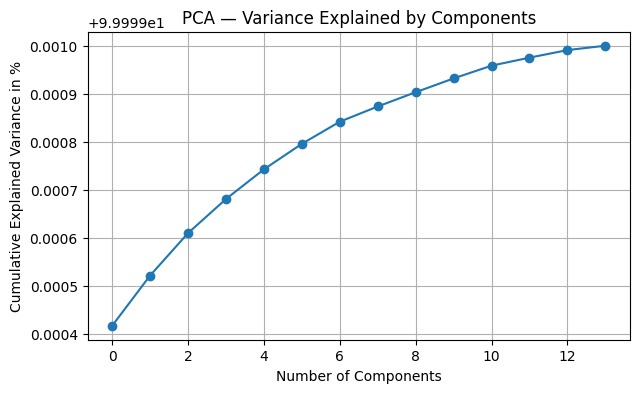

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Run PCA
pca = PCA()
pca_fit = pca.fit(df_model_scaled)

# Explained variance ratio
explained_var = pca_fit.explained_variance_ratio_

# Display variance info
print("Explained variance ratio per component:")
for i, var in enumerate(explained_var[:10]):
    print(f"PC{i+1}: {var:.4f}")

print("\nCumulative variance explained (first 10 PCs):")
print(np.cumsum(explained_var[:10]))

# Plot cumulative variance
plt.figure(figsize=(7,4))
plt.plot(np.cumsum(explained_var)*100, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance in %')
plt.title('PCA — Variance Explained by Components')
plt.grid(True)
plt.show()


## restart from here⚠️⚠️




In [25]:
# Check variance of each feature before PCA
feature_variances = pd.Series(df_model_scaled.var(axis=0), index=df_model_scaled.columns)
print("Top 10 features by variance before PCA:")
print(feature_variances.sort_values(ascending=False).head(10))

# Check if any feature has almost zero variance
low_var = (feature_variances < 1e-6).sum()
print(f"\nNumber of near-constant features (<1e-6 variance): {low_var}")

# Quick correlation overview
corr_matrix = np.corrcoef(df_model_scaled.T)
mean_corr = np.mean(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]))
print(f"\nMean absolute correlation between features: {mean_corr:.4f}")


Top 10 features by variance before PCA:
instrumentalness     1.402087e+06
speechiness          1.189846e+00
track_popularity     8.943408e-01
liveness             8.311202e-01
duration_ms          7.439015e-01
loudness             7.160870e-01
acousticness         7.145405e-01
danceability         5.666007e-01
tempo                5.156930e-01
artist_popularity    5.133728e-01
dtype: float64

Number of near-constant features (<1e-6 variance): 0

Mean absolute correlation between features: 0.0817


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_model_proc)
df_model_scaled = pd.DataFrame(X_scaled, columns=df_model_proc.columns)



AssertionError: df_model_scaled not found - run the scaling cell first.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

df_model_proc = df_model.copy()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_model_proc)

feature_names = df_model_proc.columns
df_model_scaled = pd.DataFrame(X_scaled, columns=feature_names)

feature_variances = pd.Series(df_model_scaled.var(axis=0), index=feature_names)
print("Top 10 features by variance before PCA:")
print(feature_variances.sort_values(ascending=False).head(10))

low_var = (feature_variances < 1e-6).sum()
print(f"\nNumber of near-constant features (<1e-6 variance): {low_var}")

corr_matrix = np.corrcoef(df_model_scaled.T)
mean_corr = np.mean(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]))
print(f"\nMean absolute correlation between features: {mean_corr:.4f}")


Top 10 features by variance before PCA:
mode            0.240398
key             0.108810
valence         0.059205
acousticness    0.043444
tempo           0.033524
energy          0.030292
danceability    0.030137
speechiness     0.027895
liveness        0.025639
loudness        0.009978
dtype: float64

Number of near-constant features (<1e-6 variance): 0

Mean absolute correlation between features: 0.0873


- very low correlation

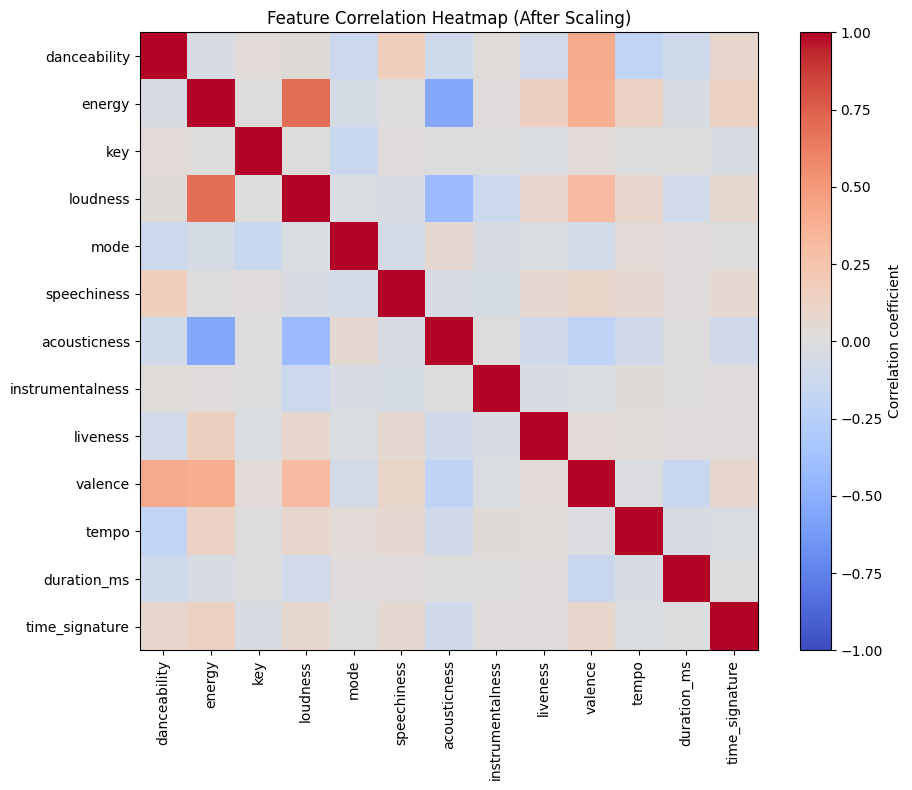

In [ ]:
import matplotlib.pyplot as plt

# Compute correlation matrix on the scaled numeric features
corr = df_model_scaled.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation coefficient')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Feature Correlation Heatmap (After Scaling)")
plt.tight_layout()
plt.show()


- lack of strong correlations